# Лабораторна робота №1, виконали Боцко Арсен та Ничипорук Дарина
### Постановки задачі та експерименту.
###     1) Алгоритми Краскала та Флойда Уоршалла

У цьому експерименті ми порівнюємо ефективність алгоритмів для пошуку мінімального остовного дерева (Крускала) і для знаходження найкоротших шляхів між усіма парами вершин (Флойда-Уоршала). Для кожного алгоритму порівнюється власна реалізація з вбудованими варіантами з бібліотеки **NetworkX**.

#### Завдання:
1. **Алгоритм Крускала**: Реалізація для пошуку мінімального остовного дерева та порівняння з вбудованим варіантом.
2. **Алгоритм Флойда-Уоршала**: Реалізація для знаходження всіх пар найкоротших шляхів та порівняння з вбудованим варіантом.
3. **Експерименти**: Виконання експериментів на графах різних розмірів. Час виконання вимірюється через 100 ітерацій для кожного набору параметрів.

#### Опис експерименту:
- Алгоритми тестуються на графах з 10, 20, 50, 100, 200 вершинами.
- Порівнюються часи виконання власних реалізацій та вбудованих алгоритмів.
- Для кожного експерименту будується графік.

#### Очікувані результати:
- Графіки, які порівнюють час виконання алгоритмів.
- Підсумки експериментів, що вказують на ефективність кожного алгоритму.



###     2) Decision Tree Classifier
**Мета**:
Завдання полягає в реалізації **класифікатороснові дерева рішень**. Модель повинна навчатися на даних, а потім передбачати для нових даних.

**Завдання**:
1. Реалізація алгоритму дерева рішень для класифікації.
2. Навчити модель на наборі даних та протетсувати її.
3. Оцінити точність моделі, порівнявши передбачення з реальними значеннями.

**Експеримент**:
- Для експерименту використовується набір даних з sklearn
- Дані розділяються на навчальну та тестову частини.
- Модель навчається на навчальних даних, а потім оцінюється на тестових.

**Очікувані результати**:
- Реалізація дерева рішень: Модель повина класифікувати нові дані.
- Точність моделі: Після навчання, модель буде оцінена на тестових даних, і на екран буде виведена точність.



In [108]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [109]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [110]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

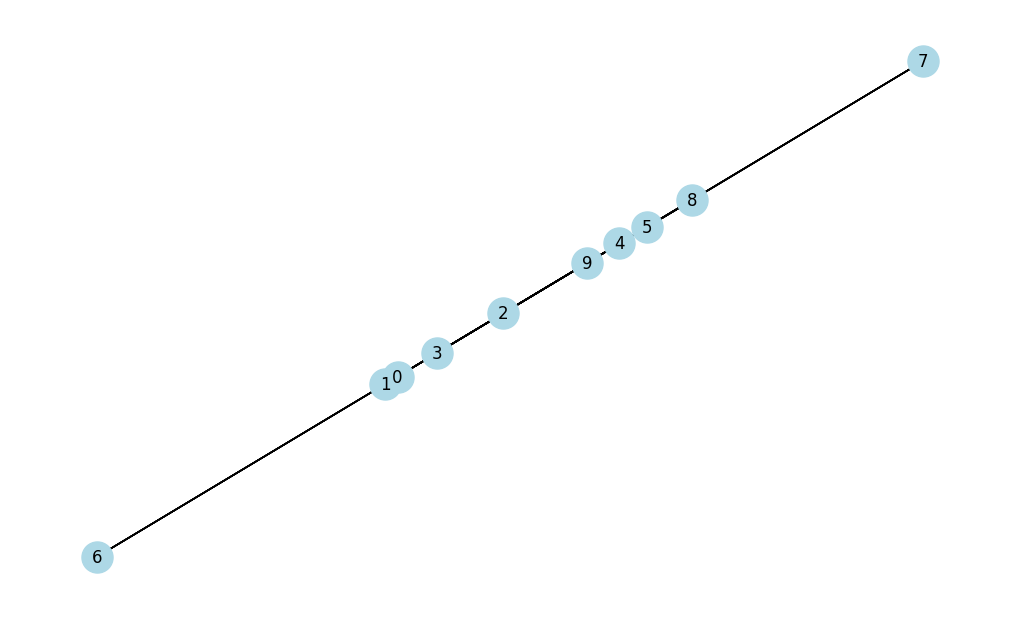

In [111]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [112]:
def networkx_kruskal(G):
    mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")
    return mstk

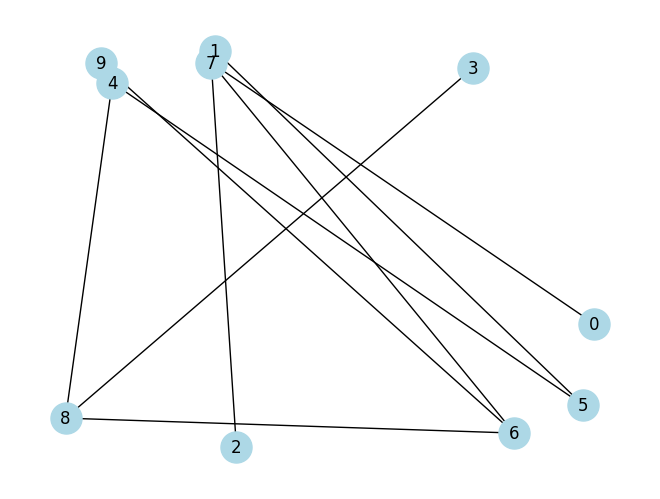

In [113]:
mstk = networkx_kruskal(G)
nx.draw(mstk, node_color='lightblue',
        with_labels=True, 
        node_size=500)

In [114]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (1, 5), (2, 7), (3, 8), (4, 5), (4, 8), (6, 8), (6, 7), (6, 9)]),
 9)

In [115]:
def kruskalas(G):
    edges = list(G.edges(data=True))
    lst = []
    for el in edges:
        edge = (el[0], el[1])
        weight = el[2].get('weight', float('inf'))
        info = edge, weight
        lst.append(info)
    sorted_lst = sorted(lst, key=lambda item: item[1])

    vertices = set()
    for (node1, node2), _ in sorted_lst:
        vertices.add(node1)
        vertices.add(node2)

    connected_vertices = {}
    carcass = []

    for (node1, node2), weight in sorted_lst:
        if node1 not in connected_vertices:
            connected_vertices[node1] = {node1}
        if node2 not in connected_vertices:
            connected_vertices[node2] = {node2}

        if not connected_vertices[node1] & connected_vertices[node2]:
            connected_vertices[node1] = connected_vertices[node1] | (connected_vertices[node2])
            connected_vertices[node2] = connected_vertices[node1]
            carcass.append(((node1, node2), weight))

        if len(carcass) == len(vertices) - 1:
            break
    return len(carcass)

### Prim's algorithm

In [116]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

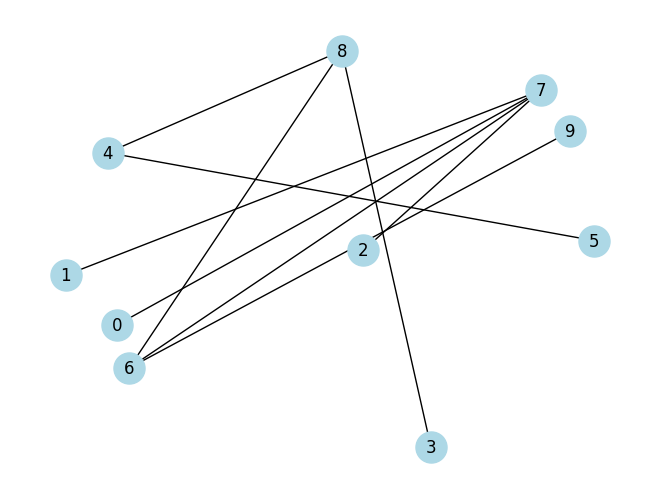

In [117]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [118]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 7), (1, 7), (2, 7), (3, 8), (4, 8), (4, 5), (6, 7), (6, 8), (6, 9)]),
 9)

*put your code below* (delete this)

## Subtask 1.2

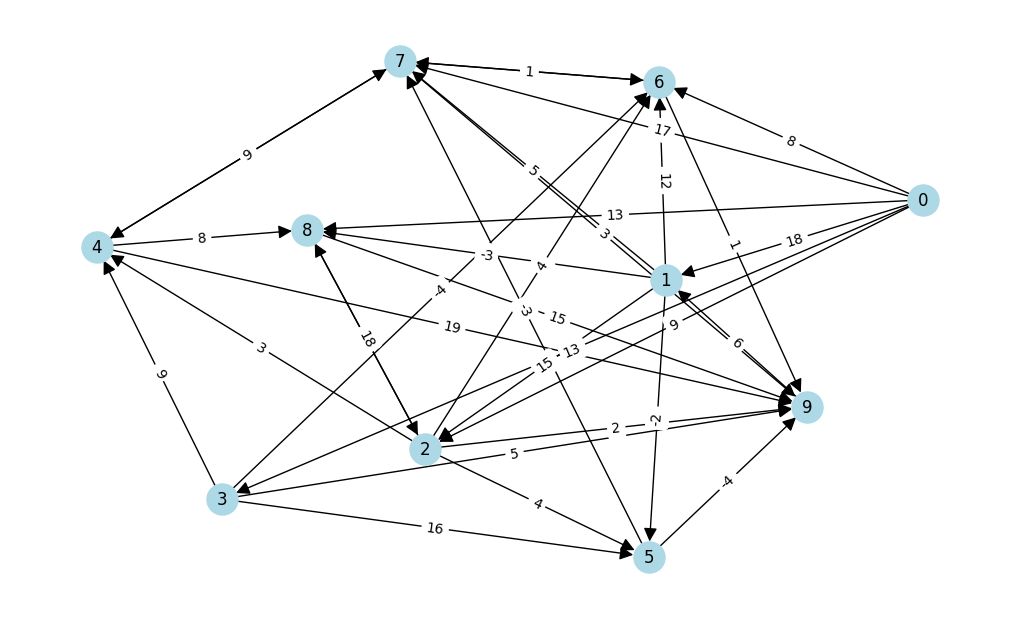

In [119]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

In [120]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 3: 13
Distance to 1: 15
Distance to 2: 9
Distance to 6: 8
Distance to 7: 10
Distance to 8: 12
Distance to 5: 13
Distance to 4: 12
Distance to 9: 9


### Floyd-Warshall algorithm

In [121]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
def floyd_warshall_networkx(G):
    try:
        pred, dist = floyd_warshall_predecessor_and_distance(G)
    except:
        print("Negative cycle detected")

In [122]:
def floyd_warshall_our(G):
    outp = []
    nodes = list(G.nodes())
    matrix = {u: {v: float('inf') for v in nodes} for u in nodes}

    for node in nodes:
        matrix[node][node] = 0

    G = G.edges(data=True)
    for u, v, data in G:
        matrix[u][v] = data.get('weight', float('inf'))

    for k in nodes:
        for i in nodes:
            for j in nodes:
                matrix[i][j] = min(matrix[i][j], matrix[i][k] + matrix[k][j])

    for k, v in matrix.items():
        outp.append(f"Distances with {k} source: {dict(v)}")

    return '\n'.join(outp)

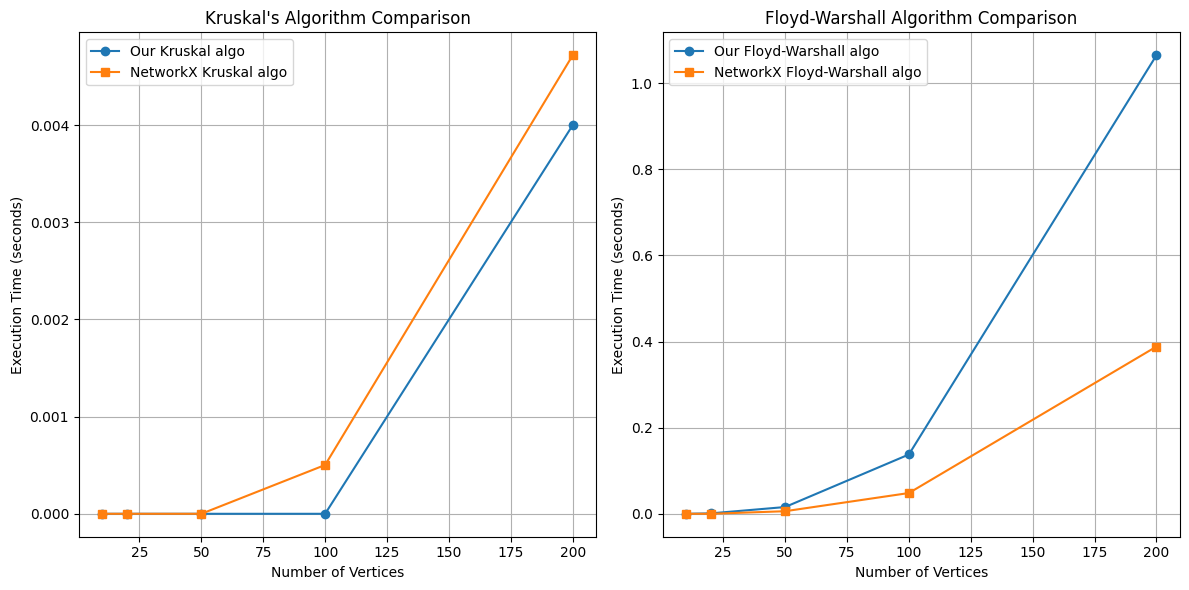

In [123]:
import time
NUM_OF_ITERATIONS = 100
VERTICES = [10, 20, 50, 100, 200]
DENSITY = 0.4

def time_measuring(G, algorithm):
    first_run = time.time()
    algorithm(G)
    first_run = time.time() - first_run

    min_time = first_run
    for _ in range(NUM_OF_ITERATIONS - 1):
        start = time.time()
        algorithm(G)
        end = time.time()
        min_time = min(min_time, end - start)
    return min_time

kruskal_our_times = []
kruskal_networkx_times = []
floyd_warshall_our_times = []
floyd_warshall_networkx_times = []

for n in VERTICES:
    G = nx.gnp_random_graph(n, DENSITY, directed=False)

    time_kruskal_our = time_measuring(G, kruskalas)
    kruskal_our_times.append(time_kruskal_our)

    time_kruskal_networkx = time_measuring(G, networkx_kruskal)
    kruskal_networkx_times.append(time_kruskal_networkx)

    time_floyd_warshall_our = time_measuring(G, floyd_warshall_our)
    floyd_warshall_our_times.append(time_floyd_warshall_our)

    time_fw_networkx = time_measuring(G, floyd_warshall_networkx)
    floyd_warshall_networkx_times.append(time_fw_networkx)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(VERTICES, kruskal_our_times, label="Our Kruskal algo", marker='o')
plt.plot(VERTICES, kruskal_networkx_times, label="NetworkX Kruskal algo", marker='s')
plt.xlabel("Number of Vertices")
plt.ylabel("Execution Time (seconds)")
plt.title("Kruskal's Algorithm Comparison")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(VERTICES, floyd_warshall_our_times, label="Our Floyd-Warshall algo", marker='o')
plt.plot(VERTICES, floyd_warshall_networkx_times, label="NetworkX Floyd-Warshall algo", marker='s')
plt.xlabel("Number of Vertices")
plt.ylabel("Execution Time (seconds)")
plt.title("Floyd-Warshall Algorithm Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Порівняння алгоритмів Крускала

Обидві версії мають схожий час виконання, але **NetworkX** виявляється трохи повільнішим на більших графах.
- Це можна пояснити тим, що наша реалізація працює безпосередньо з даними без зайвих абстракцій, тоді як **NetworkX** оптимізований для загального використання і підтримки різних випадків.
- Алгоритм **NetworkX** є повільнішим на більших графах, оскільки він є більш універсальним, і кращие підходить для практичного використання, порівняно з нашим

Варто зазначити, що наша реалізація дозволяє краще зрозуміти суть алгоритму. Проте **NetworkX** зручніший для практичного використання


### Порівняння алгоритмів Флойда-Воршала

Порівнюючи нашу реалізацію алгоритму Флойда-Воршала і **NetworkX** з **NumPy**, можна помітити, що наш алгоритм має значні затримки через вкладені цикли, тоді як **NetworkX** використовує **NumPy** для оптимізації.

Наша реалізація працює повільніше тому, що вона реалізована чистим Python з вкладеними циклами, які дуже повільно працюють на великих даних. З іншого боку, реалізація від **NetworkX** використовує **NumPy** і оптимізовані операції, тому вона набагато швидша.

Окрім швидкодії, варто зазначити, що наша реалізація більш прозора для розуміння принципу роботи алгоритму, що робить її корисною для навчання. Однак при збільшенні розміру графа вона швидко стає незручною для використання через значне зростання часу виконання.


---

## Some useful explanations
### How to get list of edges for your algorithm

In [124]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [125]:
edges[:5]

[(0, 1), (0, 2), (0, 7), (0, 9), (0, 12)]

### To get edges with weights

In [126]:
edges = list(G.edges(data=True))

In [127]:
edges[:5]

[(0, 1, {}), (0, 2, {}), (0, 7, {}), (0, 9, {}), (0, 12, {})]

In [128]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [129]:
import time
from tqdm import tqdm

In [130]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:03<00:00, 292.05it/s]


0.0009350175857543945

## Task 2. Decision Tree Classifier 

In [131]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [132]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [133]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [134]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

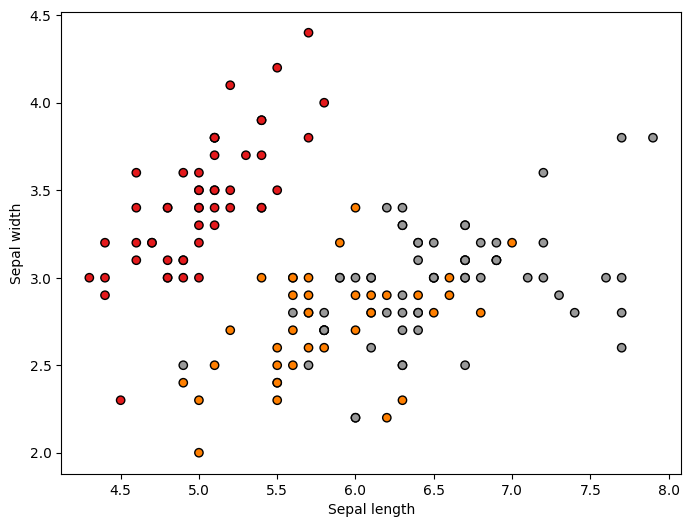

In [135]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [136]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [137]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [138]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [139]:
# import graphviz
# dot_data = tree.export_graphviz(clf, out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render("iris")

In [140]:
# dot_data = tree.export_graphviz(clf, out_file=None,
#                      feature_names=iris.feature_names,
#                      class_names=iris.target_names,
#                      filled=True, rounded=True,
#                      special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [141]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [142]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9666666666666667)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [143]:
y_test

array([2, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 1, 2, 0,
       2, 2, 2, 2, 0, 0, 2, 0])


Here you can traverse the tree above by yourself and make sure that prediction works

In [144]:
X_test[1]

array([5.1, 3.5, 1.4, 0.3])

In [145]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

### Our decision classsifier

In [146]:

class Node:
    def __init__(self, X, y, feature_index=None, threshold=None, left=None, right=None, class_value=None):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """
        self.X = X
        self.y = y
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.class_value = class_value


In [147]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Trains the decision tree classifier.

        Args:
            X: The training data features.
            y: The training data target values.
        """
        X = np.array(X)
        y = np.array(y)
        self.num_classes = len(np.unique(y))
        self.num_features = len(X[0])
        self.tree = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth=0):
        """
        Recursively builds the decision tree.

        Args:
            X: The feature values.
            y: The target values.
            depth (int): The current depth of the tree.

        Returns:
            The root node of the decision tree.
        """
        if len(y) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            node = Node(X, y)
            node.class_value = self.majority_class(y)
            return node

        best_feature, best_threshold = self.best_split(X, y)

        if best_feature is None:
            node = Node(X, y)
            node.class_value = self.majority_class(y)
            return node

        left_X, left_y, right_X, right_y = self.split(X, y, best_feature, best_threshold)
        left_node = self.build_tree(left_X, left_y, depth + 1)
        right_node = self.build_tree(right_X, right_y, depth + 1)

        node = Node(X, y)
        node.feature_index = best_feature
        node.threshold = best_threshold
        node.left = left_node
        node.right = right_node
        return node

    def best_split(self, X, y):
        """
        Finds the best feature and threshold to split on by minimizing the Gini impurity.
        Args:
            X: The feature values.
            y: The target values.

        Returns:
            (best feature index, best threshold) or (None, None) if no split is found.
        """
        m = len(y)
        if m <= 1:
            return None, None

        class_counts = [np.sum(np.array(y) == c) for c in range(self.num_classes)]
        current_gini = 1.0 - sum((count / m) ** 2 for count in class_counts)
        best_feature, best_threshold = None, None

        for feature_idx in range(self.num_features):
            sorted_indices = np.argsort(np.array(X)[:, feature_idx])
            sorted_X = np.array(X)[sorted_indices]
            sorted_y = np.array(y)[sorted_indices]

            left_counts = [0] * self.num_classes
            right_counts = class_counts[:]

            for i in range(1, m):

                class_label = sorted_y[i - 1]
                left_counts[class_label] += 1
                right_counts[class_label] -= 1

                left_gini = 1.0 - sum((left_counts[c] / i) ** 2 for c in range(self.num_classes))
                right_gini = 1.0 - sum((right_counts[c] / (m - i)) ** 2 for c in range(self.num_classes))
                gini_score = (i * left_gini + (m - i) * right_gini) / m

                if sorted_X[i, feature_idx] == sorted_X[i - 1, feature_idx]:
                    continue

                if gini_score < current_gini:
                    current_gini = gini_score
                    best_feature = feature_idx
                    best_threshold = (sorted_X[i, feature_idx] + sorted_X[i - 1, feature_idx]) / 2

        return best_feature, best_threshold

    def split(self, X, y, feature_idx, threshold):
        """
        Splits the dataset based on the feature index and threshold.

        Args:
            X: The feature values.
            y: The target values.
            feature_idx: The index of the feature to split on.
            threshold: The threshold value for the split.

        Returns:
            Four lists: left features, left targets, right features, right targets.
        """
        left_X, left_y, right_X, right_y = [], [], [], []
        for i in range(len(X)):
            if X[i][feature_idx] <= threshold:
                left_X.append(X[i])
                left_y.append(y[i])
            else:
                right_X.append(X[i])
                right_y.append(y[i])
        return left_X, left_y, right_X, right_y

    def majority_class(self, y):
        """
        Returns the majority class in the target values.

        Args:
            y: The target values.

        Returns:
            The majority class label.
        """
        return max(set(y), key=list(y).count)

    def predict_single(self, sample, node):
        """
        Predicts the class for a single sample.
        Args:
            sample: The feature values for the sample.
            node: The current node being evaluated.

        Returns:
            The predicted class label.
        """
        if node.class_value is not None:
            return node.class_value
        if sample[node.feature_index] <= node.threshold:
            return self.predict_single(sample, node.left)
        return self.predict_single(sample, node.right)

    def predict(self, X_test):
        """
        Predicts the class labels for a set of samples.
        Args:
            X_test: The feature values for the test samples.

        Returns:
            A list of predicted class labels.
        """
        X_test = np.array(X_test)
        return [self.predict_single(sample, self.tree) for sample in X_test]

In [148]:
def evaluate(X_test, y_test, model):
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)

    Args:
        X_test: The test feature values.
        y_test: The true class labels.
        model: The trained model.

    Returns:
        The accuracy of the model.
    """
    model_predictions = model.predict(X_test)
    accuracy = sum(pred == test for pred, test in zip(model_predictions, y_test)) / len(y_test)
    return accuracy

In [149]:
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data.tolist(), data.target.tolist()

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

accuracy = evaluate(X_test, y_test, model)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7333333333333333
